In [8]:
# Reference:
# /exp/rhuang/icefall_align2/egs/librispeech/ASR/ruizhe_hmm/run.ipynb
# /exp/rhuang/icefall_align2/icefall/bpe_graph_compiler.py

In [1]:
import sys
sys.path.append("/scratch4/skhudan1/rhuang25/k2/k2/python/")
sys.path.append("/scratch4/skhudan1/rhuang25/k2/build_debug/lib/")
sys.path.append("/scratch4/skhudan1/rhuang25/icefall/")
sys.path.append("/scratch4/skhudan1/rhuang25/kaldifeat/kaldifeat/python/")
sys.path.append("/scratch4/skhudan1/rhuang25/kaldifeat/build/lib/")

In [2]:
import k2
import sentencepiece as spm
import torch

In [3]:
sp = spm.SentencePieceProcessor()
sp.load("/home/rhuang25/work/icefall/egs/librispeech/ASR/data/lang_bpe_500/bpe.model")

True

In [4]:
texts = ["I DO NOT WANT TO INCUR", "THERE WAS LOVERS LIKE DOGS", "RED APP I"]
word_ids_list = sp.encode(texts, out_type=int)
word_ids_list

[[24, 102, 70, 393, 12, 17, 19, 80],
 [154, 37, 345, 21, 3, 225, 102, 52, 3],
 [49, 11, 7, 161, 24]]

In [5]:
word_ids_list = [[24, 102, 70, 393, 12, 17, 19, 80], [154, 37, 345, 21, 3, 225, 102, 52, 3]]
word_ids_list = [[24, 102, 70, 393, 12, 12, 17, 19, 80], [154, 37, 345, 21, 3, 225, 102, 52, 3]]
word_ids_list = [[24, 102, 70]]
word_ids_list = [[49, 11, 7, 161, 24]]

In [6]:
graphs = k2.ctc_graph(word_ids_list, modified=False, device='cpu')

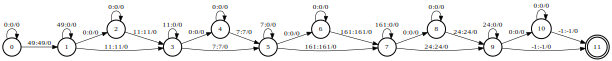

In [7]:
k2.to_dot(graphs[0])

In [8]:
graph = graphs[0]
c_str = k2.to_str_simple(graph)

In [9]:
arcs = c_str.strip().split("\n")
arcs = [x.strip() for x in arcs if len(x.strip()) > 0]
final_state = int(arcs[-1])
arcs = arcs[:-1]
arcs = [tuple(map(int, a.split())) for a in arcs]

In [11]:
arcs

[(0, 0, 0, 0, 0),
 (0, 1, 49, 49, 0),
 (1, 2, 0, 0, 0),
 (1, 1, 49, 0, 0),
 (1, 3, 11, 11, 0),
 (2, 2, 0, 0, 0),
 (2, 3, 11, 11, 0),
 (3, 4, 0, 0, 0),
 (3, 3, 11, 0, 0),
 (3, 5, 7, 7, 0),
 (4, 4, 0, 0, 0),
 (4, 5, 7, 7, 0),
 (5, 6, 0, 0, 0),
 (5, 5, 7, 0, 0),
 (5, 7, 161, 161, 0),
 (6, 6, 0, 0, 0),
 (6, 7, 161, 161, 0),
 (7, 8, 0, 0, 0),
 (7, 7, 161, 0, 0),
 (7, 9, 24, 24, 0),
 (8, 8, 0, 0, 0),
 (8, 9, 24, 24, 0),
 (9, 10, 0, 0, 0),
 (9, 9, 24, 0, 0),
 (9, 11, -1, -1, 0),
 (10, 10, 0, 0, 0),
 (10, 11, -1, -1, 0)]

In [12]:
def make_factor_transducer1(word_id_list):
    fst_graph = k2.ctc_graph([word_id_list], modified=False, device='cpu')[0]

    c_str = k2.to_str_simple(fst_graph)
    arcs = c_str.strip().split("\n")
    arcs = [x.strip() for x in arcs if len(x.strip()) > 0]
    final_state = int(arcs[-1])
    
    arcs = arcs[:-1]
    arcs = [tuple(map(int, a.split())) for a in arcs]
    # ss, ee, l1, l2, w = arc

    non_eps_nodes = set((arc[1], arc[3]) for arc in arcs if arc[3] > 0)   # if this node has a non-eps in-coming arc
    arcs += [(0, n, l, l, 0) for n, l in non_eps_nodes if n > 1]

    arcs += [(n, final_state, -1, -1, 0) for n in range(1, final_state - 2)]

    new_arcs = arcs
    new_arcs.append([final_state])

    new_arcs = sorted(new_arcs, key=lambda arc: arc[0])
    new_arcs = [[str(i) for i in arc] for arc in new_arcs]
    new_arcs = [" ".join(arc) for arc in new_arcs]
    new_arcs = "\n".join(new_arcs)

    fst = k2.Fsa.from_str(new_arcs, acceptor=False)
    return fst


In [10]:
def make_factor_transducer2(word_id_list, return_str=False, blank_penalty=-1):
    # This is the factor transducer where blank symbols at the beginning and ending of the graph is penalized
    # Last resort: use a cheap alignment model to get a subgraph of the big graph first

    # blank_penalty should be negative

    fst_graph = k2.ctc_graph([word_id_list], modified=False, device='cpu')[0]

    c_str = k2.to_str_simple(fst_graph)
    arcs = c_str.strip().split("\n")
    arcs = [x.strip() for x in arcs if len(x.strip()) > 0]
    final_state = int(arcs[-1])
    
    arcs = arcs[:-1]
    arcs = [tuple(map(int, a.split())) for a in arcs]
    # ss, ee, l1, l2, w = arc

    arc0 = arcs[0]
    arcs_last = [a for a in arcs[-5:] if a[2] > 0]

    arcs = [(0, 0, 0, 0, blank_penalty)] + arcs[1:-5] + arcs_last

    non_eps_nodes = set((arc[1], arc[3]) for arc in arcs if arc[3] > 0)   # if this node has a non-eps in-coming arc
    arcs += [(0, n, l, l, 0) for n, l in non_eps_nodes if n > 1]

    # arcs += [(n, final_state, -1, -1, 0) for n in range(1, final_state - 2)]
    arcs += [(n, final_state - 1, 0, 0, blank_penalty) for n, l in non_eps_nodes]
    arcs += [(final_state - 1, final_state - 1, 0, 0, blank_penalty)]
    arcs += [(final_state - 1, final_state, -1, -1, 0)]

    new_arcs = arcs
    new_arcs.append([final_state])

    new_arcs = sorted(new_arcs, key=lambda arc: arc[0])
    new_arcs = [[str(i) for i in arc] for arc in new_arcs]
    new_arcs = [" ".join(arc) for arc in new_arcs]
    new_arcs = "\n".join(new_arcs)

    if return_str:
        return new_arcs
    else:
        fst = k2.Fsa.from_str(new_arcs, acceptor=False)
        return fst

In [22]:
def make_factor_transducer3(word_id_list, word_start_symbols):
    fst_graph = k2.ctc_graph([word_id_list], modified=False, device='cpu')[0]

    c_str = k2.to_str_simple(fst_graph)
    arcs = c_str.strip().split("\n")
    arcs = [x.strip() for x in arcs if len(x.strip()) > 0]
    final_state = int(arcs[-1])
    
    arcs = arcs[:-1]
    arcs = [tuple(map(int, a.split())) for a in arcs]
    # ss, ee, l1, l2, w = arc

    non_eps_nodes = set((arc[1], arc[3]) for arc in arcs if arc[3] > 0 and arc[3] in word_start_symbols)   # if this node has a non-eps, word-start in-coming arc
    arcs += [(0, n, l, l, 0) for n, l in non_eps_nodes if n > 1]

    non_eps_nodes2 = set((arc[0], arc[3]) for arc in arcs if arc[3] > 0 and arc[3] in word_start_symbols)   # if this node has a non-eps, word-start out-going arc
    non_eps_nodes2 = [(n, l) for n, l in non_eps_nodes2 if 0 < n < final_state - 2]
    arcs += [(n, final_state, -1, -1, 0) for n, l in non_eps_nodes2]

    new_arcs = arcs
    new_arcs.append([final_state])

    new_arcs = sorted(new_arcs, key=lambda arc: arc[0])
    new_arcs = [[str(i) for i in arc] for arc in new_arcs]
    new_arcs = [" ".join(arc) for arc in new_arcs]
    new_arcs = "\n".join(new_arcs)

    fst = k2.Fsa.from_str(new_arcs, acceptor=False)
    return fst


In [18]:
class MyCounter: 
    def __init__(self): self.counter1 = 0; self.counter2 = 1; self.counter2_ = 0
    # def __call__(self): self.counter += 1; return self.counter
    def f1(self): 
        self.counter1 += 1; return self.counter1
    def f2(self): 
        self.counter2_ += 1; 
        if self.counter2_ % 2 == 1: self.counter2 += 1; 
        return self.counter2


def make_factor_transducer4(word_id_list, word_start_symbols):
    fst_graph = k2.ctc_graph([word_id_list], modified=False, device='cpu')[0]

    c_str = k2.to_str_simple(fst_graph)
    arcs = c_str.strip().split("\n")
    arcs = [x.strip() for x in arcs if len(x.strip()) > 0]
    final_state = int(arcs[-1])
    
    arcs = arcs[:-1]
    arcs = [tuple(map(int, a.split())) for a in arcs]
    # ss, ee, l1, l2, w = arc

    counter = MyCounter()

    non_eps_nodes1 = set((arc[1], arc[3]) for arc in arcs if arc[3] > 0 and arc[3] in word_start_symbols)   # if this node has a non-eps, word-start in-coming arc
    non_eps_nodes1 = sorted(non_eps_nodes1, key=lambda x: x[0])
    non_eps_nodes2 = list((arc[0], arc[1]) for arc in arcs if arc[3] < 0 or (arc[3] > 0 and arc[3] in word_start_symbols and arc[0] > 0))   # if this node has a non-eps, word-start out-going arc
    self_loops = {ss: l1 for ss, ee, l1, l2, w in arcs if ss == ee}

    arcs = [arcs[0]] + arcs[2:-5] + [a for a in arcs[-5:] if a[2] >= 0]
    arcs = [[ss, ee, l1, 0, w] for ss, ee, l1, l2, w in arcs]
    arcs += [(0, n, l, counter.f1(), 0) for n, l in non_eps_nodes1]
    arcs += [(n, final_state, 0, counter.f2(), 0) for n, l in non_eps_nodes2]
    arcs += [(final_state, final_state + 1, -1, -1, 0)]
    
    # non_eps_nodes2 = [(n, l) for n, l in non_eps_nodes2 if 0 < n < final_state - 2]
    
    new_arcs = arcs
    new_arcs.append([final_state + 1])

    new_arcs = sorted(new_arcs, key=lambda arc: arc[0])
    new_arcs = [[str(i) for i in arc] for arc in new_arcs]
    new_arcs = [" ".join(arc) for arc in new_arcs]
    new_arcs = "\n".join(new_arcs)

    # print(new_arcs)

    fst = k2.Fsa.from_str(new_arcs, acceptor=False)
    return fst


In [21]:
[sp.id_to_piece(i) for i in range(sp.vocab_size()) if sp.id_to_piece(i).startswith('▁')]

['▁THE',
 '▁A',
 '▁AND',
 '▁OF',
 '▁TO',
 '▁IN',
 '▁S',
 '▁I',
 '▁HE',
 '▁',
 '▁THAT',
 '▁IT',
 '▁WAS',
 '▁BE',
 '▁FOR',
 '▁C',
 '▁HIS',
 '▁YOU',
 '▁RE',
 '▁E',
 '▁WITH',
 '▁B',
 '▁HER',
 '▁AS',
 '▁P',
 '▁HAD',
 '▁SO',
 '▁IS',
 '▁T',
 '▁NOT',
 '▁BUT',
 '▁F',
 '▁ON',
 '▁SHE',
 '▁DE',
 '▁ME',
 '▁AT',
 '▁ST',
 '▁G',
 '▁NO',
 '▁HIM',
 '▁W',
 '▁WE',
 '▁ALL',
 '▁DO',
 '▁HAVE',
 '▁MY',
 '▁BY',
 '▁THIS',
 '▁WHICH',
 '▁CON',
 '▁THEY',
 '▁TH',
 '▁D',
 '▁GO',
 '▁SAID',
 '▁FROM',
 '▁WHO',
 '▁ONE',
 '▁CA',
 '▁O',
 '▁LA',
 '▁WERE',
 '▁AN',
 '▁MAN',
 '▁FA',
 '▁OR',
 '▁MI',
 '▁SH',
 '▁MO',
 '▁EX',
 '▁HA',
 '▁SU',
 '▁BO',
 '▁WHEN',
 '▁FI',
 '▁MA',
 '▁PRO',
 '▁WOULD',
 '▁HO',
 '▁THERE',
 '▁WHAT',
 '▁FE',
 '▁PA',
 '▁PO',
 '▁OUT',
 '▁IF',
 '▁THEIR',
 '▁LI',
 '▁RO',
 '▁ARE',
 '▁WILL',
 '▁UP',
 '▁SEE',
 '▁WA',
 '▁UN',
 '▁SP',
 '▁LO',
 '▁YE',
 '▁LE',
 '▁BEEN',
 '▁RA',
 '▁COULD',
 '▁DIS',
 '▁THEM',
 '▁SA',
 '▁SOME',
 '▁NE',
 '▁CO',
 '▁MORE',
 '▁US',
 '▁K',
 '▁EN',
 '▁INTO',
 '▁KNOW',
 '▁YOUR',
 '▁TIME',
 '▁NO

In [23]:
# graph_ft = make_factor_transducer1(word_ids_list[0])
# graph_ft = make_factor_transducer2(word_ids_list[0])
graph_ft = make_factor_transducer3(word_ids_list[0], word_start_symbols=[i for i in range(sp.vocab_size()) if sp.id_to_piece(i).startswith('▁')])
# graph_ft = make_factor_transducer4(word_ids_list[0], word_start_symbols=[i for i in range(sp.vocab_size()) if sp.id_to_piece(i).startswith('▁')])

In [12]:
graph_ft.arcs.values()

tensor([[          0,           0,           0, -1082130432],
        [          0,           1,          49,           0],
        [          0,           7,         161,           0],
        [          0,           5,           7,           0],
        [          0,           9,          24,           0],
        [          0,           3,          11,           0],
        [          1,           2,           0,           0],
        [          1,           1,          49,           0],
        [          1,           3,          11,           0],
        [          1,          10,           0, -1082130432],
        [          2,           2,           0,           0],
        [          2,           3,          11,           0],
        [          3,           4,           0,           0],
        [          3,           3,          11,           0],
        [          3,           5,           7,           0],
        [          3,          10,           0, -1082130432],
        

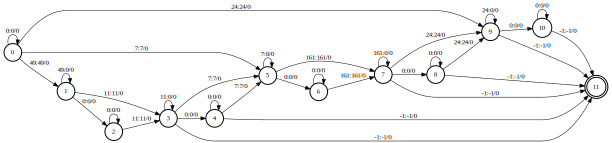

In [24]:
k2.to_dot(graph_ft)

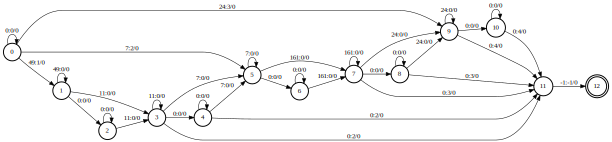

In [20]:
k2.to_dot(graph_ft)

In [19]:
graph_ft.labels

tensor([  0,  49,   7,  24,   0,  49,  11,   0,  11,   0,  11,   7,  -1,   0,
          7,  -1,   0,   7, 161,   0, 161,   0, 161,  24,  -1,   0,  24,  -1,
          0,  24,  -1,   0,  -1], dtype=torch.int32)

In [20]:
graph_ft.aux_labels

tensor([  0,  49,   7,  24,   0,   0,  11,   0,  11,   0,   0,   7,  -1,   0,
          7,  -1,   0,   0, 161,   0, 161,   0,   0,  24,  -1,   0,  24,  -1,
          0,   0,  -1,   0,  -1], dtype=torch.int32)

In [33]:
fst = k2.random_fsa(max_symbol=20, acyclic=True, min_num_arcs=10, max_num_arcs=100)
# fst = k2.random_fsa_vec()
fst.shape, fst.num_arcs

((7, None), 22)

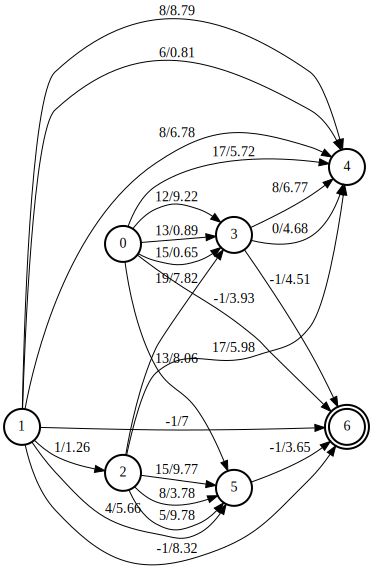

In [34]:
k2.to_dot(fst)

In [56]:
fst.labels

tensor([12, 13, 15, 17, 13, -1, -1,  8,  6,  8, -1,  1,  4,  8,  5, 19, 15, 17,
         8,  0, -1, -1], dtype=torch.int32)

In [57]:
fst.aux_labels = torch.randint(0, 20, (fst.labels.size(0), 2))
fst.aux_labels

tensor([[ 4, 13],
        [ 6,  0],
        [18, 15],
        [14,  1],
        [17, 14],
        [ 8, 13],
        [ 4,  5],
        [ 6, 11],
        [ 0,  1],
        [ 8,  8],
        [16,  7],
        [12, 12],
        [15,  1],
        [ 4, 18],
        [19,  7],
        [17, 13],
        [ 1, 17],
        [ 7, 15],
        [16, 11],
        [15, 15],
        [13,  6],
        [10,  1]])

In [58]:
# path = k2.random_paths(k2.create_fsa_vec([fst]), use_double_scores=True, num_paths=1)[0]
path = k2.shortest_path(k2.create_fsa_vec([fst]), use_double_scores=True)[0]
path.shape, path.num_arcs

((3, None), 2)

In [ ]:
k2.to_dot(path)

In [60]:
path.labels

tensor([12, -1], dtype=torch.int32)

In [61]:
path.aux_labels

tensor([[ 4, 13],
        [13,  6]])

In [62]:
# https://github.com/k2-fsa/k2/blob/master/k2/python/k2/utils.py#L211
fst.arcs.values()

tensor([[         0,          3,         12, 1091794564],
        [         0,          3,         13, 1063589961],
        [         0,          3,         15, 1059495981],
        [         0,          4,         17, 1085729510],
        [         0,          5,         13, 1090585249],
        [         0,          6,         -1, 1081850848],
        [         1,          6,         -1, 1090854872],
        [         1,          4,          8, 1091347737],
        [         1,          4,          6, 1062094748],
        [         1,          4,          8, 1087955214],
        [         1,          6,         -1, 1088414084],
        [         1,          2,          1, 1067554743],
        [         1,          5,          4, 1085605546],
        [         2,          5,          8, 1081199325],
        [         2,          5,          5, 1092383131],
        [         2,          3,         19, 1090147204],
        [         2,          5,         15, 1092372563],
        [     